In [61]:
%matplotlib inline
import keras.backend as K

## Tell Tensorflow to use no more GPU RAM than necessary

In [2]:
K.get_session().close()
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

## prepare files

In [10]:
import glob
from PIL import Image
import numpy as np

In [4]:
fnames = glob.glob('train/*/*.JPEG', recursive=True)
len(fnames)

19439

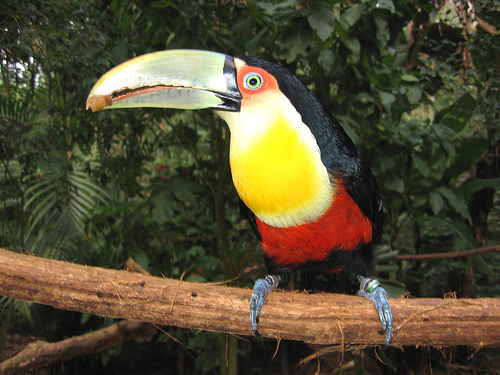

In [94]:
img = Image.open(fnames[100]); img

In [11]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

In [12]:
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [96]:
img_arr = preproc(np.expand_dims(np.array(img), 0))
shp = img_arr.shape
shp

(1, 375, 500, 3)

## recreate input with vgg16 (avg pooling)

In [22]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D, AveragePooling2D
from keras.applications.imagenet_utils import _obtain_input_shape

In [44]:
K.set_image_dim_ordering('tf')
input_shape = (375, 500, 3)
input_shape

(375, 500, 3)

In [45]:
img_input = Input(shape=input_shape)
# Block 1
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = AveragePooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = AveragePooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
x = AveragePooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

# Block 4
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
x = AveragePooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

# Block 5
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
x = AveragePooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

inputs = img_input
model = Model(inputs, x, name='vgg16')
model.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 375, 500, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 375, 500, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 375, 500, 64)      36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, 187, 250, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 187, 250, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 187, 250, 128)     147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, 93, 125, 128)      0         
__________

In [111]:
layer = model.get_layer('block5_conv1').output
layer_model = Model(model.input, layer)
targ = K.variable(layer_model.predict(img_arr))

In [80]:
from keras import metrics
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import matplotlib.pyplot as plt

In [112]:
#loss = metrics.mse(layer, targ)
loss = K.mean(metrics.mse(layer, targ))
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss]+grads)
loss, layer, targ

(<tf.Tensor 'Mean_13:0' shape=() dtype=float32>,
 <tf.Tensor 'block5_conv1_1/Relu:0' shape=(?, 23, 31, 512) dtype=float32>,
 <tf.Variable 'Variable_2:0' shape=(1, 23, 31, 512) dtype=float32_ref>)

In [113]:
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)
evaluator = Evaluator(fn, shp)

In [114]:
def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        #print(x.shape, min_val.shape)
        imsave(f'results/res_at_iteration_{i}.png', deproc(x.copy(), shp)[0])
    return x

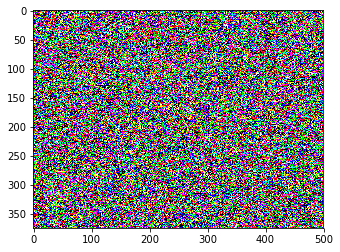

In [115]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(shp)
plt.imshow(x[0]);

In [116]:
iterations=10
x = solve_image(evaluator, iterations, x)

Current loss value: 82.409362793
Current loss value: 29.9771766663
Current loss value: 17.2948684692
Current loss value: 12.3447856903
Current loss value: 9.63659667969
Current loss value: 7.92918205261
Current loss value: 6.79442310333
Current loss value: 6.01431465149
Current loss value: 5.43277454376
Current loss value: 5.03320074081


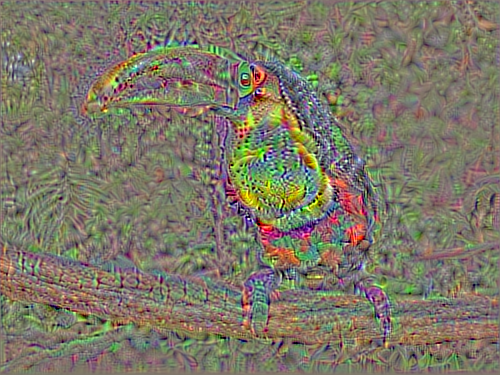

In [117]:
Image.open('results/res_at_iteration_1.png')

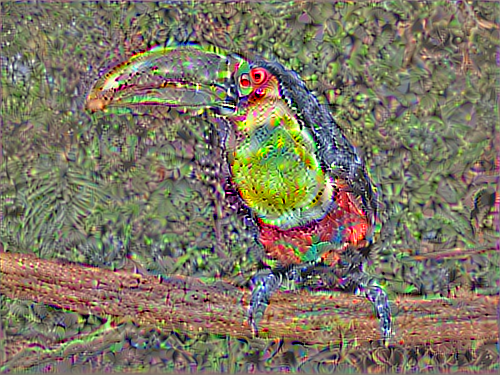

In [118]:
Image.open('results/res_at_iteration_9.png')

RuntimeError: No MovieWriters available!

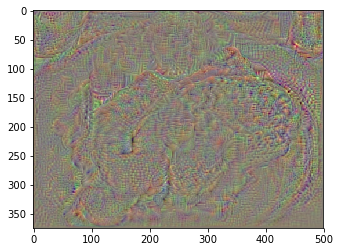

In [91]:
from IPython.display import HTML
from matplotlib import animation, rc
fig, ax = plt.subplots()
def animate(i):
    ax.imshow(Image.open(f'results/res_at_iteration_{i}.png'))
anim = animation.FuncAnimation(fig, animate, frames=10, interval=200)
HTML(anim.to_html5_video())

No MovieWriters available http://forums.fast.ai/t/runtimeerror-no-moviewriters-available/1888